In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, FFMpegWriter  
import datetime
from itertools import product

In [2]:
df = pd.read_pickle(f'../../../siads591 data/gabbard/gabbard_out_20072009_1d.pkl')
# df = pd.read_pickle(f'../../../siads591 data/gabbard/gabbard_out_19992001_1d.pkl')
# df = pd.read_pickle(f'../../../siads591 data/gabbard/debris_gabbard_raw_5D_1960.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274249 entries, 0 to 7274248
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   EPOCH         datetime64[ns]
 1   NORAD_CAT_ID  uint64        
 2   PERIOD        float32       
 3   APOAPSIS      float32       
 4   PERIAPSIS     float32       
dtypes: datetime64[ns](1), float32(3), uint64(1)
memory usage: 194.2 MB


In [3]:
dates = pd.date_range(start=df.EPOCH.min(), end=df.EPOCH.max(), freq='5D')
# dates = dates.delete([1490,1620,1749,-1])
# 1490 = 1981-01-08       3
# 1620 = 1982-10-20      55
# 1749 = 1984-07-26    1111
# -1 is latest entry, with some data missing

2007
2008
2009


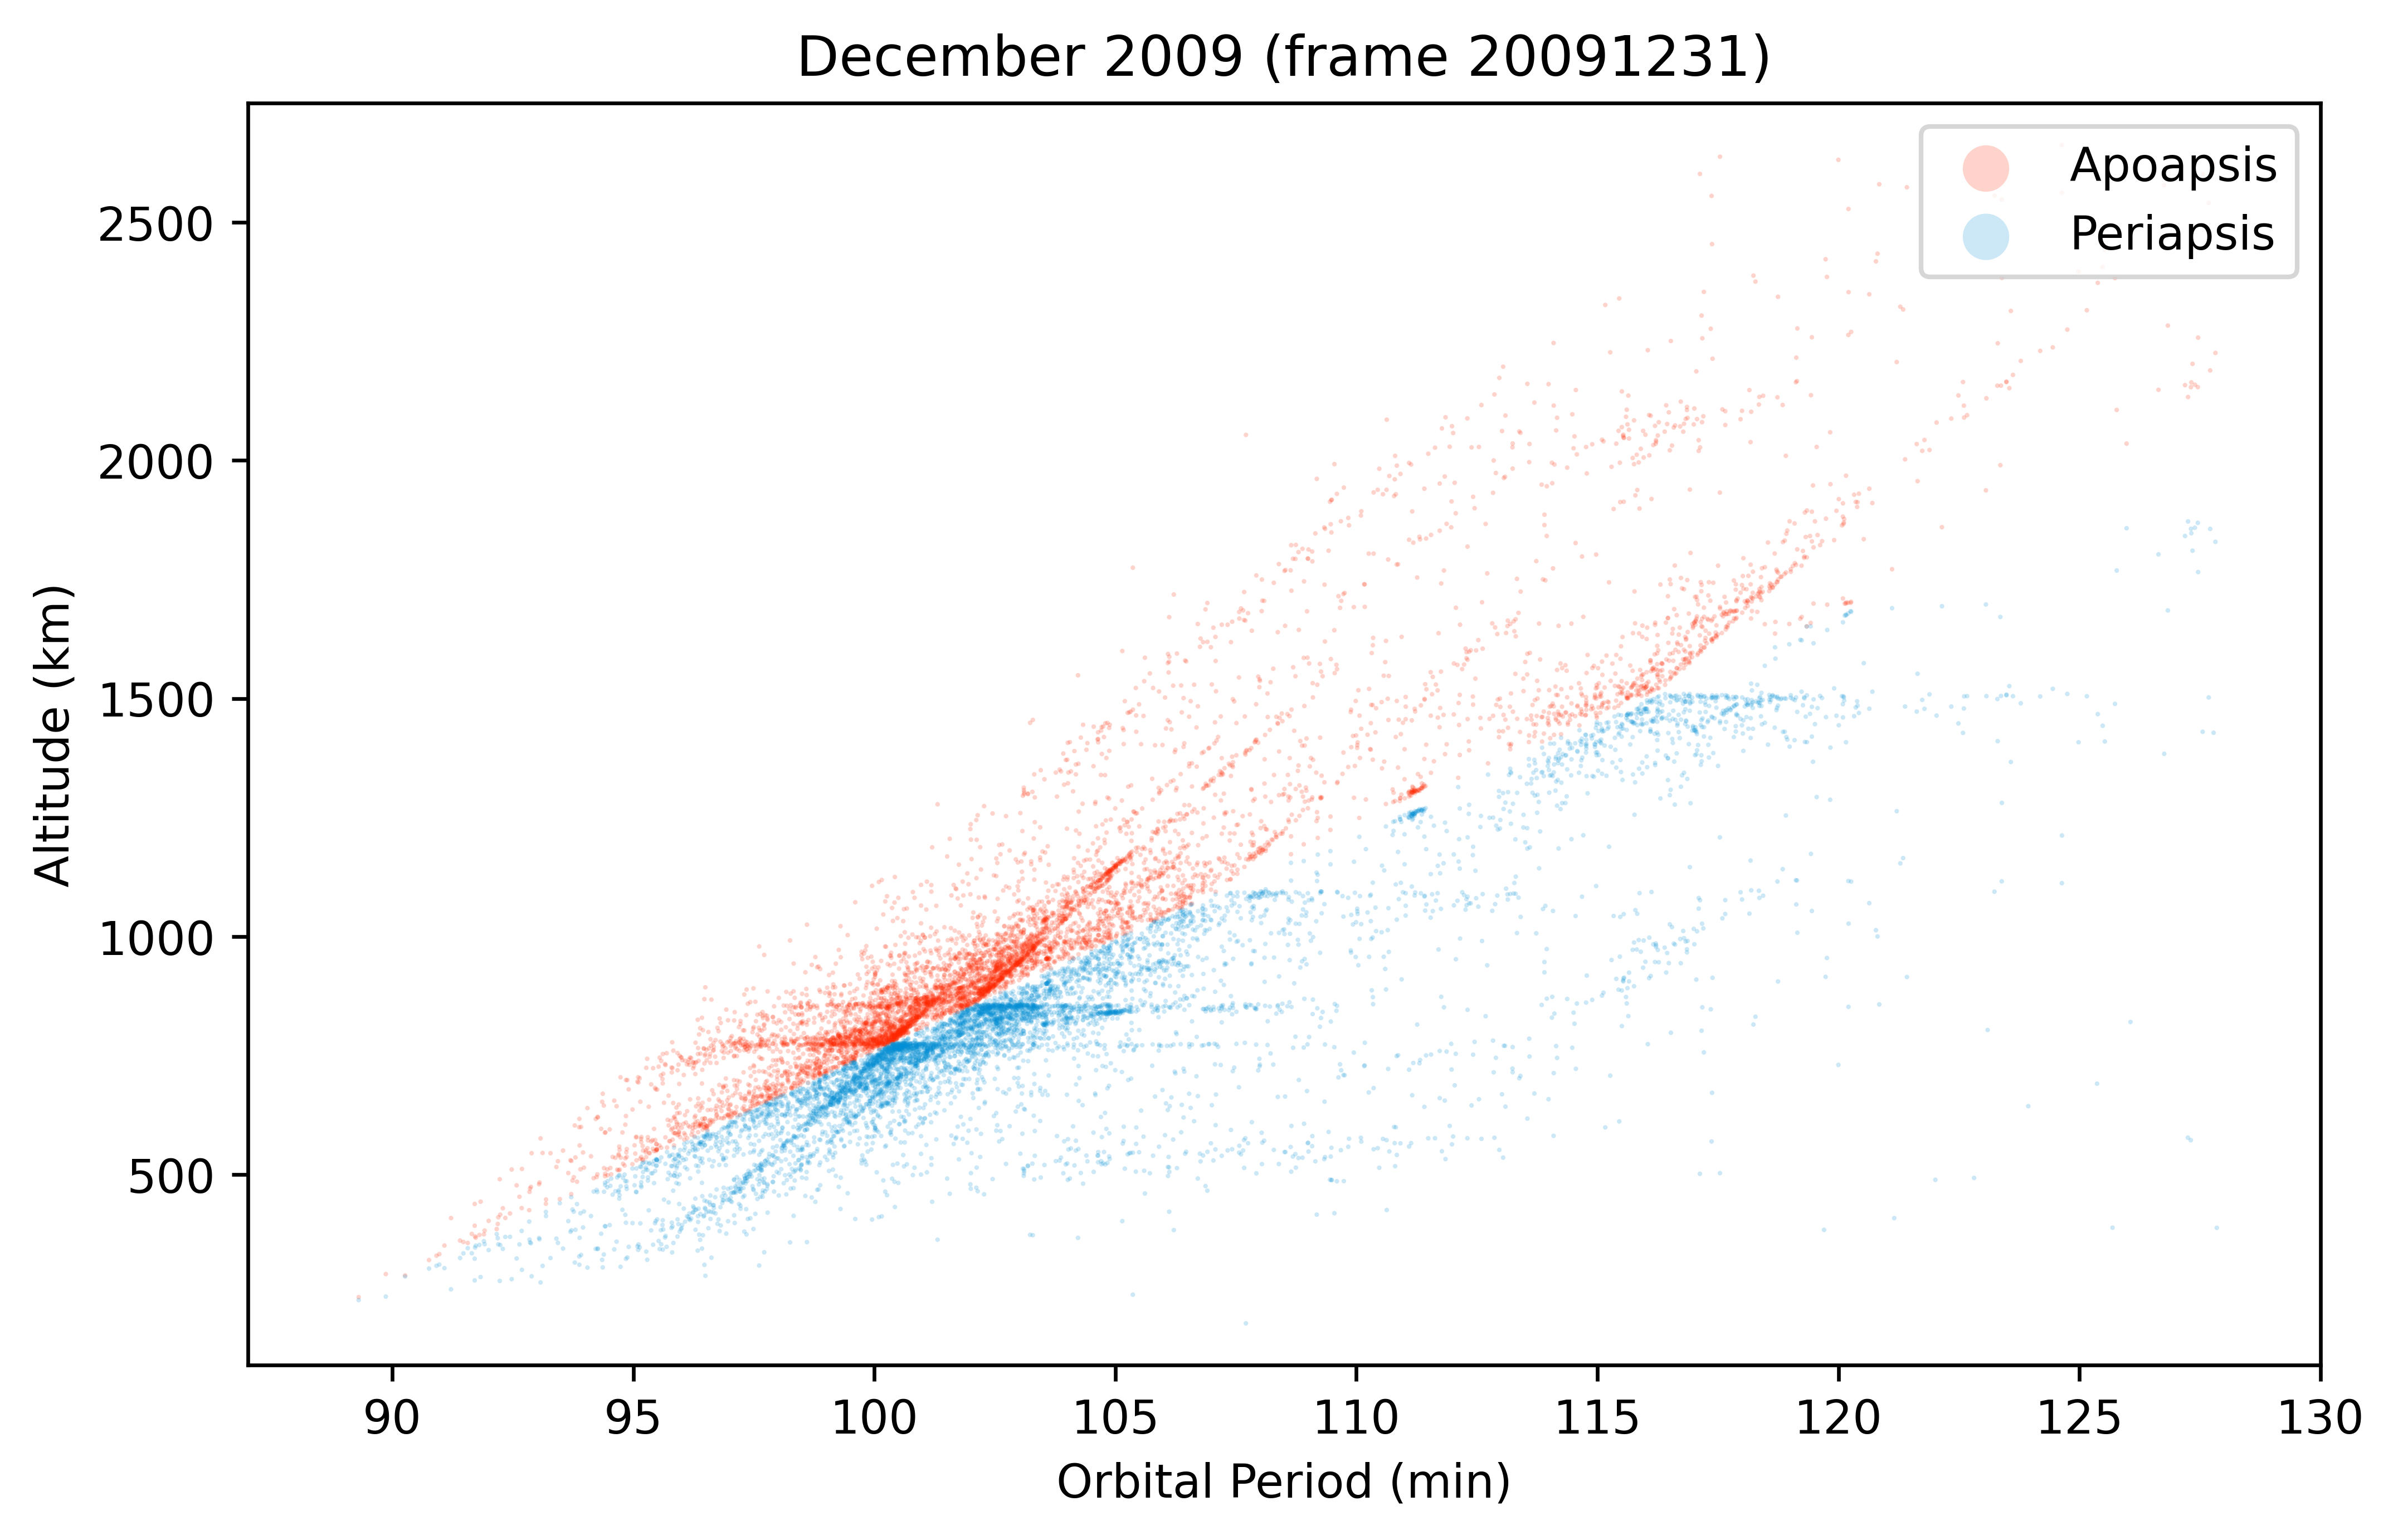

In [4]:
fig, ax = plt.subplots(dpi=600, figsize=(8,5))

ax.set_xlim(87,130)
ax.set_ylim(100,2750)
ax.set_xlabel("Orbital Period (min)")
ax.set_ylabel("Altitude (km)")
artists = []
yr = 0

def plot_it(ax,e):
    global df
    cdf = df[df.EPOCH==e]
    apo = ax.scatter(cdf.PERIOD, cdf.APOAPSIS, color='#fe2700', marker='o', edgecolors='none', alpha=0.2, s=1, label="Apoapsis")
#     ax.scatter(wdf[:500].PERIOD, wdf[:500].APOAPSIS, color='cyan', marker='o', edgecolors='none', alpha=0.5, s=1)
    
    peri = ax.scatter(cdf.PERIOD, cdf.PERIAPSIS, color='#038fd5', marker='o', edgecolors='none', alpha=0.2, s=1, label="Periapsis")
#     ax.scatter(wdf[:500].PERIOD, wdf[:500].PERIAPSIS, color='lightcoral', marker='o', edgecolors='none', alpha=0.5, s=1)
    plt.legend(loc="upper right", numpoints=1, fontsize=10, markerscale=10)
    
    return [apo,peri]

def update(frame):
    global artists, yr
    if frame.year != yr:
        yr = frame.year
        print(yr)
    ax.set_title(f"{frame.month_name()} {frame.year} (frame {frame.year}{str(frame.month).zfill(2)}{str(frame.day).zfill(2)})")
    for a in artists:
        a.remove()
    artists = plot_it(ax,frame)

# update(dates[2100])
ani = FuncAnimation(fig, update, dates)
writervideo = FFMpegWriter(fps=30, bitrate=600)
ani.save("out.mp4", writer=writervideo, dpi=600)

In [5]:
# df[(df.EPOCH==dates[2100]) & (df.PERIAPSIS.between(840,845))]

<AxesSubplot:>

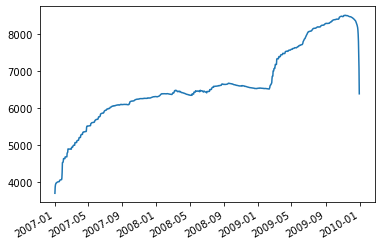

In [6]:
df.EPOCH.value_counts(sort=False).plot()

In [7]:
counts = df[df.EPOCH.between("1972","1987")].EPOCH.value_counts(sort=False)
counts[counts < 1300].sort_index()

Series([], Name: EPOCH, dtype: int64)

Can probably hide these frames without people noticing.  They are causing quick flicker due to missing a lot of data

```
1981-01-08       3
1982-10-20      55
1984-07-26    1111
```